# ***CODING STYLE EXPLANATION | PLEASE READ CAREFULLY TO MAKE YOUR LIFE EASIER | THIS CODE IS FOR DESCIPTIVE PURPOSES ONLY***

In this notebook a different coding style is being used compared to the other ones. Generally one can trivially write a classifier network as follow:

In [ ]:
class ToyClassifierNetwork(nn.Module):
  def __init__(self, in_channels, conv_out_channels, no_classes, image_size=96):

    super(ToyClassifierNetwork, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels=in_channels, 
        out_channels=conv_out_channels, 
        kernel_size=3, 
        stride= 2,
        padding=1, 
    )
    
    self.conv2 =  nn.Conv2d(
        in_channels=conv_out_channels, 
        out_channels=conv_out_channels*2, 
        kernel_size=3, 
        stride=2,
        padding=1, 
    ) 

    in_features = (image_size/2**2)**2*conv_out_channels*2

    self.linear1 = nn.Linear(
        in_features=in_features
        out_features=in_features//2
    )

    self.linear2 = nn.Linear(
        in_features=in_features//2,
        out_features=3
    )
    
    self.activation = nn.LeakyReLU(inplace=False)

    torch.nn.init.xavier_normal_(self.conv1.weight.data)
    torch.nn.init.xavier_normal_(self.conv2.weight.data)
    torch.nn.init.xavier_normal_(self.linear1.weight.data)
    torch.nn.init.xavier_normal_(self.linear2.weight.data)

  def forward(self, x):
    out = self.conv1(x)
    out = self.activation(out)

    out = self.conv2(out)
    out = self.activation(out)

    out = torch.flatten(out, start_dim=1)

    out = self.linear1(out)
    out = self.activation(out)

    out = self.linear2(out)

    return out

But one can use torch's Dictionaries or Lists to store programatically defined network layers. It helps you have more control over the network structure without risking introducing bugs every time you want to add or substract just a few layers. That will look as follows:



In [ ]:
class ToyClassifierNetwork(nn.Module):
  def __init__(
      self, 
      in_channels, 
      conv_out_channels,
      no_classes,
      no_convolutions=2, 
      no_linears=2, 
      image_size=96
  ):

    super(ToyClassifierNetwork, self).__init__()
    
    layers = torch.nn.ModuleDict()

    self.no_convolutions=no_convolutions
    self.no_linears=no_linears

    out_channels = conv_out_channels

    for i in range(no_convolutions):
      layers[f"conv_{i}"] = nn.Conv2d(
          in_channels=in_channels, 
          out_channels=out_channels, 
          kernel_size=3, 
          stride= 2,
          padding=1, 
      )
      in_channels = out_channels
      out_channels = out_channels*2
    
    in_features = (image_size/2**no_convolutions)**2*out_channels
    out_features = in_channels // 2 
    for i in range(no_linears-1):
      layers[f"linear_{i}"] = nn.Linear(
        in_features=in_features
        out_features=out_features
      )
      in_features = out_features
      out_features = out_features//2


    layers[f"linear_{i+1}"] = nn.Linear(
      in_features=out_features
      out_features=3
    )
    
    self.activation = nn.LeakyReLU(inplace=False)

    for m in self.modules():
      torch.nn.init.xavier_normal_(self.m.weight.data)

  def forward(self, x):
    out=x
    for i in range(self.no_convolutions):
        out=layers[f"conv_{i}"](out)
        out = self.activation(out)

    for i in range(self.no_linears-1)
        out=layers[f"linear_{i}"](out)
        out = self.activation(out)

    out = layers[f"linear_{i+1}"](out)

    return out

# Needed Setup
1.   Download the zip from [here]("https://drive.google.com/file/d/1k4HtSIgw4knZh2nqU66AbD7cnlaocDPJ/view?usp=sharing") 
2.   Upload it into "/content/" also know as root in colab aka not in a folder
4.   Run the cell bellow

In [ ]:
!apt install unzip
!unzip "/content/"data.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
unzip:  cannot find or open /content/data/data.tar, /content/data/data.tar.zip or /content/data/data.tar.ZIP.


# Imports and Parameters

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from glob import glob
from os.path import join
from os import listdir
from pathlib import Path
from collections import OrderedDict

from tqdm import tqdm

from PIL import Image

from torch import optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.nn.modules.loss import L1Loss
from torch.nn.modules.loss import MSELoss
from torchsummary import summary

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


PCA_PARAMETERS = {
    "n_components":2,
    "copy":True,
    "whiten":False,
    "svd_solver": "auto",
    "tol": 0,
    "iterated_power": "auto",
    "random_state": 0
}

NETWORK_LENGTH = 2
NETWORK_DEPTH = 4
FEATURE_SIZE = 2
BATCH_SIZE = 32
WORKERS = 4
EPOCHS = 50

def numpy_from_tensor(x):
  return x.detach().cpu().numpy()

ModuleNotFoundError: No module named 'numpy.testing.decorators'

# Dataset Loader

(96, 96)


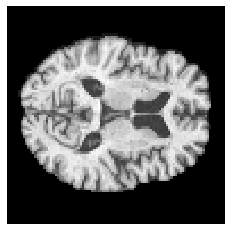

In [ ]:
class NiftyDataset(Dataset):
  '''
    Class that loads nii files, resizes them to 96x96 and feeds them
  '''
  def __init__(self,root_dir):
    '''
      root_dir - string - path towards the folder containg the data
    '''
    # Save the root_dir as a class variable
    self.root_dir = root_dir
    # Save the filenames in the root_dir as a class variable
    self.filenames = listdir(self.root_dir)
  
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self,idx):
    # Fetch file filename
    img_name = self.filenames[idx]
    # Load the nifty image
    img = nib.load(os.path.join(self.root_dir,img_name))
    # Get the voxel values as a numpy array
    img = np.array(img.get_data())
    # Expanding the array with 1 new dimension as feature channel
    img = np.expand_dims(img, 0)

    return img

# Loading the data
training_dataset = NiftyDataset(
    root_dir=join("/content/gdrive/My Drive/phd/aml_unsupervised_learning_lecture/data/training")
)
testing_dataset = NiftyDataset(
    root_dir=join("/content/gdrive/My Drive/phd/aml_unsupervised_learning_lecture/data/testing")
)

# Create the required DataLoaders for training and testing
training_loader = DataLoader(
    training_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=WORKERS,
    drop_last=True
)
testing_loader = DataLoader(
    testing_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=WORKERS,
    drop_last=True
)

# Show a random image from training
plt.imshow(np.squeeze(next(iter(training_dataset))), cmap="gray")
plt.axis('off')
plt.show()

# Traning the network

Code the training loop for the network:
*   Loss function needs to be L1 (MAE) + L2 (MSE)
*   Compute the predictions
*   Compute the gradients
*   Optimize the variables
*   Compute test predictions
*   Compute average test dataset loss

In [ ]:
def display_results(x, x_hat): 
  x = numpy_from_tensor(x[0])
  x_hat = numpy_from_tensor(x_hat[0])

  plt.figure()
  f, axarr = plt.subplots(1, 3) 

  axarr[0].imshow(np.squeeze(x), cmap="gray") 
  axarr[0].axis('off')
  axarr[0].title.set_text("Input")
  
  axarr[1].imshow(np.squeeze(x-x_hat), cmap="gray")
  axarr[1].axis('off')
  axarr[1].title.set_text("Residual")
  
  axarr[2].imshow(np.squeeze(x_hat), cmap="gray")
  axarr[2].axis('off')
  axarr[2].title.set_text("Reconstruction")
  
  plt.show()

def train_network(training_loader, testing_loader, network):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  network.cuda(device)

  optimizer = optim.Adam(network.parameters(), lr=0.001)

  l1_loss = L1Loss()
  l2_loss = MSELoss()

  # Train the network
  for epoch in range(EPOCHS):
    for x in training_loader:
      # Move input to device
      x = x.to(device, dtype=torch.float)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # TODO:Forward pass
      x_hat = network(x)

      # TODO:Calculate losses
      loss = l1_loss(x, x_hat) + l2_loss(x, x_hat)

      # TODO:Back-propagation of gradients
      loss.backward()

      # TODO:Optimize
      optimizer.step()

    if epoch % 10 == 0:
      # TODO:Initialize loss acumulators
      l1_test_loss = 0 
      l2_test_loss = 0 
      for i, x in enumerate(testing_loader):
        x = x.to(device, dtype=torch.float)

        # TODO:Forward pass
        x_hat = network(x)

        # TODO:Calculate losses
        l1_test_loss = l1_test_loss + l1_loss(x, x_hat)
        l2_test_loss = l2_test_loss + l2_loss(x, x_hat)
    
      print(
          "==== Epoch: " + str(epoch) + 
          " | L1 loss: " + str(numpy_from_tensor(l1_test_loss/i)) + 
          " | L2 loss: " + str(numpy_from_tensor(l2_test_loss/i)) +
          " | Total Loss: " + str(numpy_from_tensor((l1_test_loss+l2_test_loss)/i))+ " =====")
      display_results(x, x_hat)
  return network

# Network structure
The network will be composed mainly of _Residual blocks_ which are coded for you bellow and _Linear_ layers.

The structure is _Encoder_ -> _Code processor_ -> _Decoder_ where the _Code processor_ will will be changed to fit different types of networks. 

The _Encoder_ and the _Decoder_ will be __fully convolutional neural networks__.

When coding please keep in mind that you should code in a modula way.

# Residual block

For the purpose of this tutorial you should aim to use the *ResBlock* as the bulding block of your _Encoder_ and _Decoder_. It should **not** be used in any of the *Code Processors*.

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, mode="level"):
    '''
      in_channels - integer - the number of feature channels the first 
                              convolution will receive
      out_channels - integer - the number of feature channels the last
                               convolution will output
      mode - string - defines what the block will do
           - "upsample" means the block wil double the spatial size
           - "downsample" means the block will halve the spatial size
           - "level" means the block will not change the spatial dimension
    '''
    super(ResBlock, self).__init__()

    if mode == "upsample":
      self.conv1 = nn.ConvTranspose2d(
          in_channels=in_channels, 
          out_channels=out_channels, 
          kernel_size=4, 
          stride=2 ,
          padding=1, 
      )

      self.conv1b = nn.ConvTranspose2d(
          in_channels=in_channels, 
          out_channels=out_channels, 
          kernel_size=4, 
          stride=2 ,
          padding=1, 
      )
    else:  
      self.conv1 = nn.Conv2d(
          in_channels=in_channels, 
          out_channels=out_channels, 
          kernel_size=3, 
          stride=2 if mode == "downsample" else 1,
          padding=1, 
      )

      self.conv1b = nn.Conv2d(
          in_channels=in_channels, 
          out_channels=out_channels, 
          kernel_size=3, 
          stride=2 if mode == "downsample" else 1,
          padding=1, 
      )
    
    self.conv2 =  nn.Conv2d(
        in_channels=out_channels, 
        out_channels=out_channels, 
        kernel_size=3, 
        stride=1,
        padding=1, 
    ) 
    
    self.activation = nn.LeakyReLU(inplace=False)

    torch.nn.init.xavier_normal_(self.conv1.weight.data)
    torch.nn.init.xavier_normal_(self.conv1b.weight.data)
    torch.nn.init.xavier_normal_(self.conv2.weight.data)

  def forward(self, x):
    out = self.conv1(x)
    out = self.activation(out)

    skip = self.conv1b(x)

    out = self.conv2(out)
    out += skip

    out = self.activation(out)

    return out

# Encoder

The *Encoder* is a fully convolutional neural network that that **takes** a tensor of size **(-1, 1, 64, 64)** and **outputs** a tensor of size **(-1, 32, 4, 4)**.

----

To do:
*   Use **only** *ResBlocks* to **complete** the network
*   While doing so you **need** to modify the *in_chanels* and *feature_size*





In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_channels, depth, length, feature_size):
    super(Encoder, self).__init__()
    encoder = OrderedDict()

    for l in range(0, length - 1, 1):
      #TODO:Create a ResBlock to have the desired initial
      #     feature size
      encoder["encoder-depth_0-length_"+str(l)]=ResBlock(
        in_channels=in_channels, 
        out_channels=feature_size, 
        mode="level"
      )
      in_channels = feature_size      
    for d in range(1, depth + 1, 1):
      #TODO:Modify the in_chanels and feature_size accoringly
      in_channels = feature_size
      feature_size *= 2
      #TODO:Create a ResBlock to downsample to the desired
      #     feature size
      encoder["encoder-depth_"+str(d)+"-downsample"]=ResBlock(
        in_channels=in_channels, 
        out_channels=feature_size, 
        mode="downsample"
      )
      for l in range(0, length - 1, 1):
        #TODO:Create a ResBlock to further process the data
        #     keep it at the same feature depth and resolution
        encoder["encoder-depth_"+str(d)+"-length_"+str(l)]=ResBlock(
          in_channels=feature_size, 
          out_channels=feature_size, 
          mode="level"
        )
    self.encoder = nn.Sequential(encoder)

  def forward(self, x):
    return self.encoder(x)

# Decoder

The *Decoder* is a fully convolutional network that **takes** a tensor of size **(-1, 32, 4, 4)** and **outputs** a tensor of size **(-1, 1, 64, 64)**.

----

To do : 
*   Use **only** *ResBlocks* to **complete** the network
*   While doing so you **need** to modify *feature_size* and *in_channels*




In [ ]:
class Decoder(nn.Module):
  def __init__(self, in_channels, depth, length, reconstruction_channels):
    super(Decoder, self).__init__()
    decoder = OrderedDict()

    #TODO:Calculate the initial feature_size
    feature_size = in_channels//2

    for d in range(depth, 0, -1):
      #TODO:Create a ResBlock to upsample to the desired feature
      #     size
      decoder["decoder-depth_"+str(d)+"-upsample"]=ResBlock(
        in_channels=in_channels, 
        out_channels=feature_size, 
        mode="upsample"
      )

      for l in range(0, length - 1, 1):
        #TODO:Create a ResBlock to further process the data keep
        #     it at the same feature depth and resolution
        decoder["decoder-depth_"+str(d)+"-length_"+str(l)]=ResBlock(
          in_channels=feature_size, 
          out_channels=feature_size, 
          mode="level"
        )
        
      #TODO:Modify the in_chanels and feature_size accoringly
      in_channels = feature_size
      feature_size = in_channels//2

    #TODO:Create the a ResBlock that outputs the required number
    #     of channels for the output
    decoder["decoder-depth_0-reconstruction"]= ResBlock(
      in_channels=in_channels, 
      out_channels=reconstruction_channels, 
      mode="level"
    )

    self.decoder = nn.Sequential(decoder)

  def forward(self,x):
    return self.decoder(x)

# Unsupervised Network
The *Unsupervised Network* is the class that glues all the components (*Encoder*, *Code Processor*, *Decoder*) that you will use togheter. 

Its aim is to take an image and give you the reconstruction. It should also be able to encode image, and decode codes. 

----

To do:
*   **Call** the code processor to process the *Encoder's* output so that is passed to the *Decoder*
*   **Call** the needed methods to procces the latent representation of the *Encoder* and get a **code**, and a **code** to get a **spatial latent reprentation**

----

Tip:
*   Any *Code processor* will **have** an **encode** and **decode** method



In [ ]:
class UnsupervisedNetwork(nn.Module):
  def __init__(self, encoder, code_processor, decoder):
    super(UnsupervisedNetwork, self).__init__()
    self.encoder = encoder
    self.code_processor = code_processor
    self.decoder = decoder

  def forward(self, x):
    x = self.encoder(x)
    
    #TODO:Process encoder's latent representation
    #     to go through the code and get the desired
    #     input for the decoder
    x = self.code_processor(x)
    
    x = self.decoder(x)

    return x

  def encode(self, x):
    x = self.encoder(x)
    #TODO:Process encoder's latent representation
    #     to obtain the code
    x = self.code_processor.encode(x)

    return x

  def decode(self, x):
    #TODO:Process a code to get the required input
    #     for the decoder
    x = self.code_processor.decode(x)
    x = self.decoder(x)
    return x

# Dense Auto Encoder
In a *Dense AutoEncoder* the *Code Processor* receives the latent representation of the *Encoder* and then flattens it into a 1D array. Following that it is further compressed until the desired code dimension. Then it decompresses it while keepint it a 1D array. Finally it reshapes it so it can be passed.

----

To do:
*   Complete the Dense autoencoder with **Linear** layers 
*   Code the functionality for forward pass, encoding and decoding

----

Tips:
*   Look at [flatten layer](https://pytorch.org/docs/stable/nn.html#torch.nn.Flatten) and pay attention to the **start_dim** parameter.
*   Look at the [view](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) method of tensors 
*   Be careful with the feature sizes, you might need to be able to calculate them


In [ ]:
class DenseAECodeProcessor(nn.Module):
  def __init__(self, feature_size, depth, img_sizes, encoding_sizes, decoding_sizes):
    super(DenseAECodeProcessor, self).__init__()

    feature_depth = feature_size * np.power(2, depth)
    img_sizes = [img_size/np.power(2,depth) for img_size in img_sizes]

    flatten_size = int(feature_depth * np.prod(img_sizes))

    ecoding_processor = OrderedDict()

    in_features = flatten_size

    #TODO:Given a list of Linear layers output sizes compress the
    #     feature to the desired code size
    for i in range(len(encoding_sizes)):
      ecoding_processor["ecoding_flatten_" + str(i)] = nn.Linear(
          in_features=in_features, 
          out_features=encoding_sizes[i],
      )
      in_features = encoding_sizes[i]

    self.ecoding_processor = nn.Sequential(ecoding_processor)

    decoding_processor = OrderedDict()

    #TODO:Given a list of Linear layers output sizes decomporess the
    #     feature to the desired size
    for i in range(len(decoding_sizes)):
      decoding_processor["decoding_flatten_" + str(i)] = nn.Linear(
          in_features=in_features, 
          out_features=decoding_sizes[i],
      )
      in_features = decoding_sizes[i]
    
    decoding_processor["flatten_" + str(i+1)] = nn.Linear(
      in_features=in_features, 
      out_features=flatten_size,
    )

    self.decoding_processor = nn.Sequential(decoding_processor)

  def forward(self, x):
    #TODO:Remember the sample tensor shape
    self.spatial_shape = x.shape[1:]

    #TODO:Prepare encoder's latent representation to be processed 
    #     by the Linear layers
    x = torch.flatten(x, start_dim=1)
    
    x = self.ecoding_processor(x)
    
    x = self.decoding_processor(x)
    
    #TODO:Prepare the tensor to be passed to the decoder
    x = x.view((-1, ) + self.spatial_shape)

    return x

  def encode(self, x):
    #TODO:Prepare encoder's latent representation to be processed 
    #     by the Linear layers
    x = torch.flatten(x, start_dim=1)
    x = self.ecoding_processor(x)
    
    return x

  def decode(self, x):
    #TODO:Prepare the tensor to be passed to the decoder
    x = self.decoding_processor(x)
    x = x.view((-1, ) + self.spatial_shape)

    return x

Lets now train the network and see what we get!

==== Epoch: 0 | L1 loss: 0.23358437 | L2 loss: 0.07266942 | Total Loss: 0.3062538 =====


<Figure size 432x288 with 0 Axes>

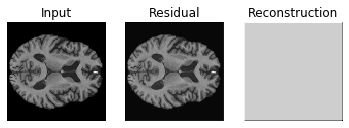

==== Epoch: 10 | L1 loss: 0.23227838 | L2 loss: 0.07108011 | Total Loss: 0.3033585 =====


<Figure size 432x288 with 0 Axes>

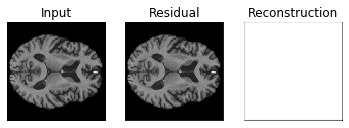

KeyboardInterrupt: ignored

In [ ]:
network = UnsupervisedNetwork(
  encoder=Encoder(
    in_channels=1, 
    depth=NETWORK_DEPTH, 
    length=NETWORK_LENGTH, 
    feature_size=FEATURE_SIZE
  ),
  code_processor=DenseAECodeProcessor(**{
    "feature_size":FEATURE_SIZE, 
    "depth":NETWORK_DEPTH, 
    "img_sizes":[192,192], 
    "encoding_sizes":[1024,512,256],
    "decoding_sizes":[512,1024],
  }),
  decoder=Decoder(
    in_channels=np.power(FEATURE_SIZE,NETWORK_DEPTH+1), 
    depth=NETWORK_DEPTH, 
    length=NETWORK_LENGTH, 
    reconstruction_channels=1
  ),
)

network = train_network(training_loader, testing_loader, network)


# Dimensionality reduction visualization

The *dimensionality_reduction_analysis* method given a training dataset loader, a testing dataset loader and a network will show a scatter plot of a 2D PCA dimensionality reduction of training and testing samples.

----

To do:
*   Reshape the numpy arrays into the needed shape to be fed into PCA
*   Project the *training_encodings* into 2D
*   Project the *testing_encodings* into 2D

----

Tips
*    Might wanna look at [numpy.reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html)

In [ ]:
def dimensionality_reduction_analysis(training_loader, testing_loader, network):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  network.cuda(device)

  training_encodings = None
  for x in training_loader:
    x = x.to(device, dtype=torch.float)
    x = network.encode(x)
    x = numpy_from_tensor(x)
    training_encodings =  (
        x if training_encodings is None
        else np.concatenate((training_encodings, x), axis=0)
    )
  training_encodings = np.array(training_encodings)
  #TODO:Reshape the data to be fed into PCA
  training_encodings = training_encodings.reshape(
      training_encodings.shape[0],
      -1
  )

  testing_encodings = None
  for x in testing_loader:
    x = x.to(device, dtype=torch.float)
    x = network.encode(x)
    x = numpy_from_tensor(x)
    testing_encodings =  (
        x if testing_encodings is None
        else np.concatenate((testing_encodings, x), axis=0)
    )
  testing_encodings = np.array(testing_encodings)
  #TODO:Reshape the data to be fed into PCA
  testing_encodings = testing_encodings.reshape(
      testing_encodings.shape[0],
      -1
  )

  pca = PCA(**PCA_PARAMETERS)
  #TODO:Do dimensionality reduction on training encodings
  training_reduction = pca.fit_transform(training_encodings)
  #TODO:Do dimensionality reduction on testing encodings
  testing_reduction = pca.transform(testing_encodings)

  fig, ax = plt.subplots()
  ax.scatter(
    x=training_reduction[:,0], 
    y=training_reduction[:,1],
    c="blue",
    label="Training Data"
  )
  ax.scatter(
    x=testing_reduction[:,0], 
    y=testing_reduction[:,1],
    c="red",
    label="Testing Data"
  )
  ax.set_xlabel("Dimension 1")
  ax.set_ylabel("Dimension 2")
  
  min_x = np.min([np.min(training_reduction[:,0]),np.min(testing_reduction[:,0])])
  min_x = min_x - np.abs(min_x*0.25)

  max_x = np.max([np.max(training_reduction[:,0]),np.max(testing_reduction[:,0])])
  max_x = max_x + max_x*0.25
  
  ax.set_xlim(min_x,max_x)
  
  min_y = np.min([np.min(training_reduction[:,1]),np.min(testing_reduction[:,1])])
  min_y = min_y - np.abs(min_y*0.25)

  max_y = np.max([np.max(training_reduction[:,1]),np.max(testing_reduction[:,1])])
  max_y = max_y + max_y*0.25

  ax.set_ylim(min_y,max_y)
  plt.legend(loc = 'best')
  plt.show()
  plt.close()

Now lets see what we get if we run it!

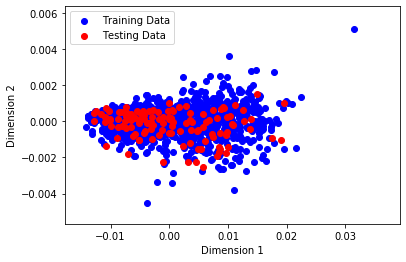

In [ ]:
dimensionality_reduction_analysis(
  training_loader=training_loader,
  testing_loader=testing_loader,
  network=network
)

# Interpolation 
The *interpolation_analysis* method given a training dataset loader, a testing dataset loader and a network will show:
*   An interpolation between two training samples
*   An interpolation between two testing samples
*   And two interpolations between training and testing samples

For two encodings ${z}_{1}$ and ${z}_{2}$ and a decoder $D$ interpolation can be defined as: $D({z}_{1}*(1-\alpha)+\alpha*{z}_{2})$

----

To do:
*   Calculate alpha based codes
*   Get the samples based on those codes

----

Tips:
*   Do not worry if it does not look like you expect, it takes a lot of time for interpolation to work.

In [ ]:
def interpolation_analysis(training_loader, testing_loader, network):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  network.cuda(device)

  training_batch = next(iter(training_loader))
  training_sample_0 = training_batch[0]
  training_sample_1 = training_batch[1]

  testing_batch = next(iter(testing_loader))
  testing_sample_0 = testing_batch[0]
  testing_sample_1 = testing_batch[1]

  combinations={
      "Training samples":(training_sample_0, training_sample_1),
      "Testing samples": (testing_sample_0, testing_sample_1),
      "Training to Testing 1": (training_sample_0, testing_sample_0),
      "Training to Testing 2": (training_sample_1, testing_sample_1)
  }

  for name, samples in combinations.items():
    sample_0 = samples[0].to(device, dtype=torch.float).unsqueeze(0)
    sample_1 = samples[1].to(device, dtype=torch.float).unsqueeze(0)

    code_0 = network.encode(sample_0)
    code_1 = network.encode(sample_1)
    for i, alpha in enumerate(np.linspace(0,1,5)):
      #TODO:Calcualte the interpolation code
      alpha_code = code_0*(1-alpha) + code_1*alpha
      #TODO:Get the interpolated sample
      alpha_sample = numpy_from_tensor(network.decode(alpha_code))

      plt.figure()
      f, ax = plt.subplots()
      ax.imshow(np.squeeze(alpha_sample), cmap="gray") 
      ax.axis('off')
      ax.title.set_text(name + " | Interpolation " + str(i))
      plt.show()
      plt.close()

Now lets see what we get if we run it!

<Figure size 432x288 with 0 Axes>

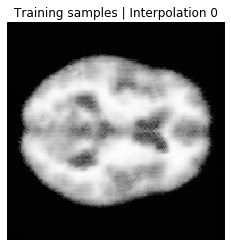

<Figure size 432x288 with 0 Axes>

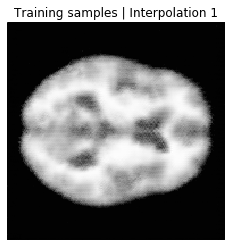

<Figure size 432x288 with 0 Axes>

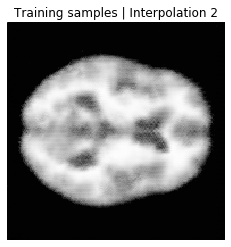

<Figure size 432x288 with 0 Axes>

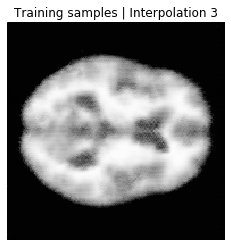

<Figure size 432x288 with 0 Axes>

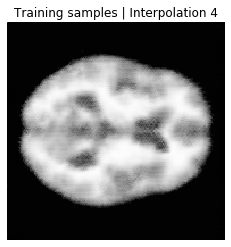

<Figure size 432x288 with 0 Axes>

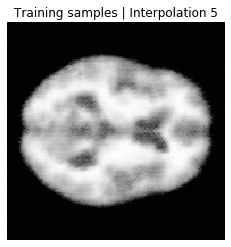

<Figure size 432x288 with 0 Axes>

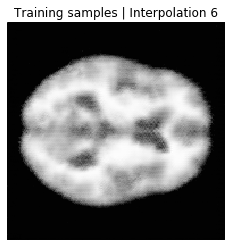

<Figure size 432x288 with 0 Axes>

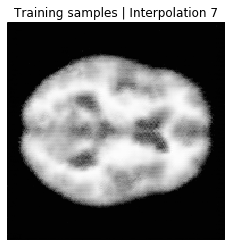

<Figure size 432x288 with 0 Axes>

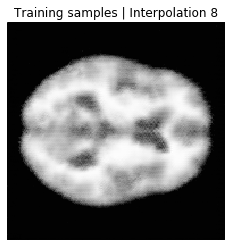

<Figure size 432x288 with 0 Axes>

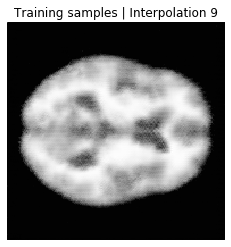

<Figure size 432x288 with 0 Axes>

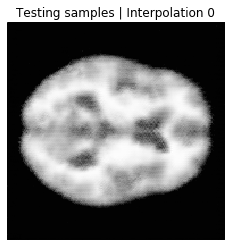

<Figure size 432x288 with 0 Axes>

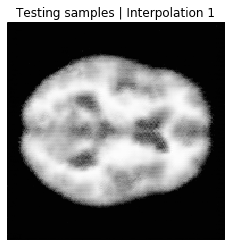

<Figure size 432x288 with 0 Axes>

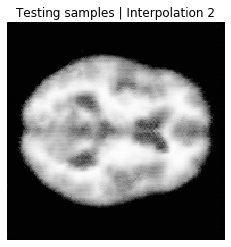

<Figure size 432x288 with 0 Axes>

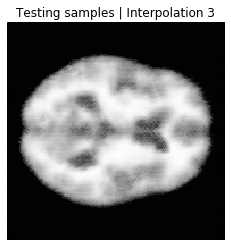

<Figure size 432x288 with 0 Axes>

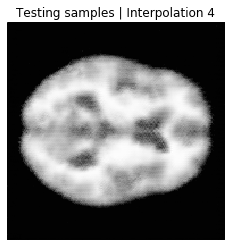

<Figure size 432x288 with 0 Axes>

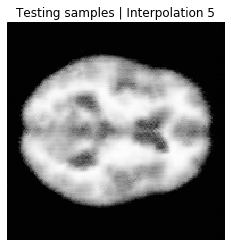

<Figure size 432x288 with 0 Axes>

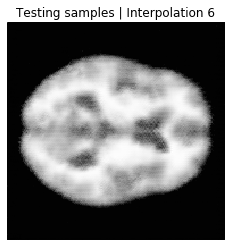

<Figure size 432x288 with 0 Axes>

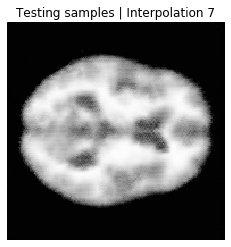

<Figure size 432x288 with 0 Axes>

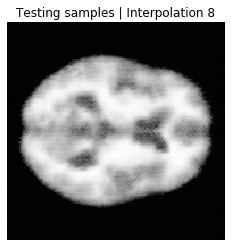

<Figure size 432x288 with 0 Axes>

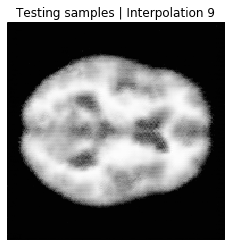

<Figure size 432x288 with 0 Axes>

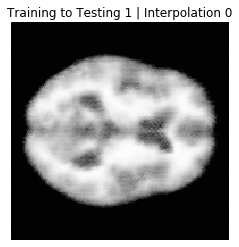

<Figure size 432x288 with 0 Axes>

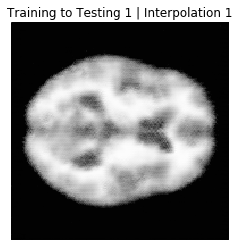

<Figure size 432x288 with 0 Axes>

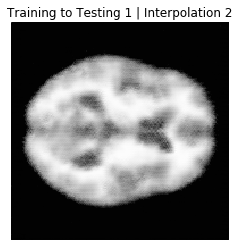

<Figure size 432x288 with 0 Axes>

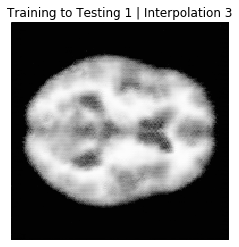

<Figure size 432x288 with 0 Axes>

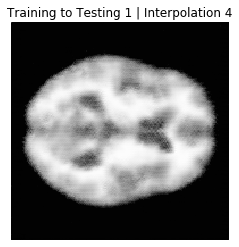

<Figure size 432x288 with 0 Axes>

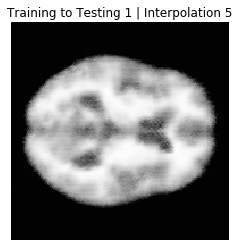

<Figure size 432x288 with 0 Axes>

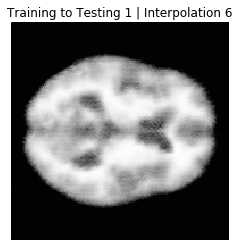

<Figure size 432x288 with 0 Axes>

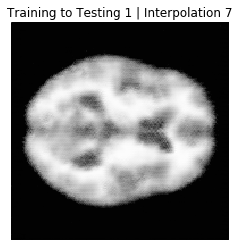

<Figure size 432x288 with 0 Axes>

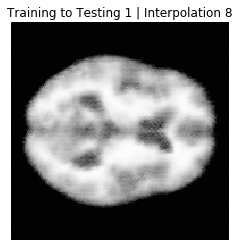

<Figure size 432x288 with 0 Axes>

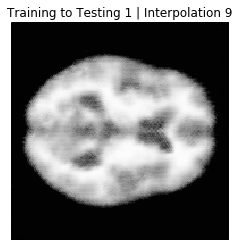

<Figure size 432x288 with 0 Axes>

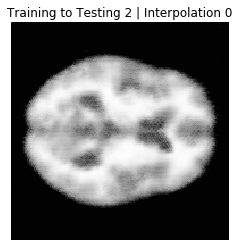

<Figure size 432x288 with 0 Axes>

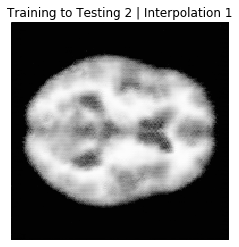

<Figure size 432x288 with 0 Axes>

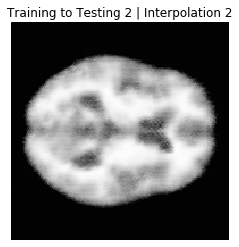

<Figure size 432x288 with 0 Axes>

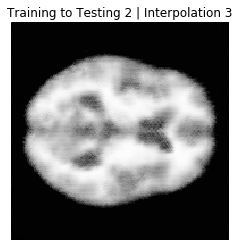

<Figure size 432x288 with 0 Axes>

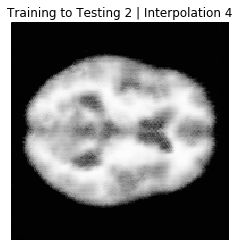

<Figure size 432x288 with 0 Axes>

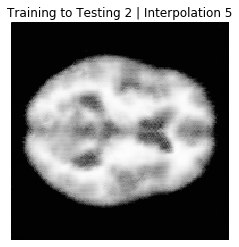

<Figure size 432x288 with 0 Axes>

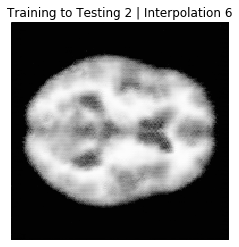

<Figure size 432x288 with 0 Axes>

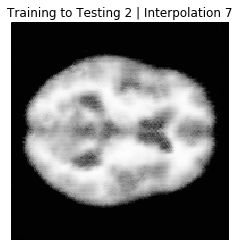

<Figure size 432x288 with 0 Axes>

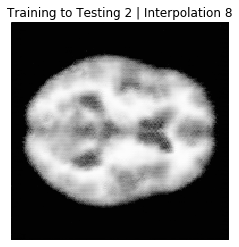

<Figure size 432x288 with 0 Axes>

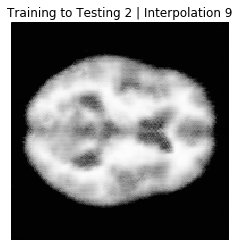

In [ ]:
interpolation_analysis(
  training_loader=training_loader,
  testing_loader=testing_loader,
  network=network
)

# Experiment design
Now you need to put everything togheter and make it as a single experiment.

----

To do:
*    Compile the network definition, network training, dimensionality reductiona and interpolation analysis into a single method that can be later used.

----

Tips:
*   Do not overthink it

In [ ]:
def experiment(code_processor_class, code_processor_parameters, network_depth, network_length, feature_size):
  #TODO:Put togheter the creation of the network, the training 
  #     and two analysis that you have coded up until now. This
  #     method should only **call** the other ones
  network = UnsupervisedNetwork(
    encoder=Encoder(
      in_channels=1, 
      depth=network_depth, 
      length=network_length, 
      feature_size=feature_size
    ),
    code_processor=code_processor_class(**code_processor_parameters),
    decoder=Decoder(
      in_channels=np.power(feature_size,network_depth+1), 
      depth=network_depth, 
      length=network_length, 
      reconstruction_channels=1
    ),
  )

  network = train_network(
      training_loader=training_loader,
      testing_loader=testing_loader,
      network=network,
  )

  dimensionality_reduction_analysis(
      training_loader=training_loader,
      testing_loader=testing_loader,
      network=network
  )

  interpolation_analysis(
      training_loader=training_loader,
      testing_loader=testing_loader,
      network=network,
  )

Now lets see what we get if we run it!

==== Epoch: 0 | L1 loss: 0.14240582 | L2 loss: 0.04740385 | Total Loss: 0.18980968 =====


<Figure size 432x288 with 0 Axes>

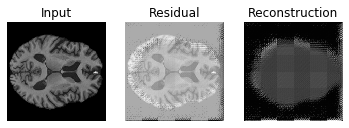

==== Epoch: 10 | L1 loss: 0.07386526 | L2 loss: 0.015361292 | Total Loss: 0.08922655 =====


<Figure size 432x288 with 0 Axes>

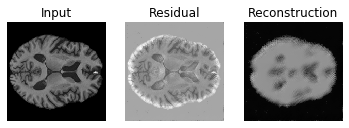

==== Epoch: 20 | L1 loss: 0.056678575 | L2 loss: 0.010388416 | Total Loss: 0.06706699 =====


<Figure size 432x288 with 0 Axes>

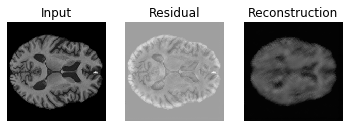

==== Epoch: 30 | L1 loss: 0.05435492 | L2 loss: 0.009612166 | Total Loss: 0.06396709 =====


<Figure size 432x288 with 0 Axes>

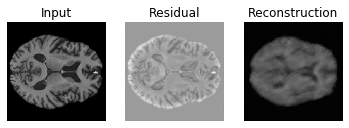

==== Epoch: 40 | L1 loss: 0.053376824 | L2 loss: 0.009582455 | Total Loss: 0.062959276 =====


<Figure size 432x288 with 0 Axes>

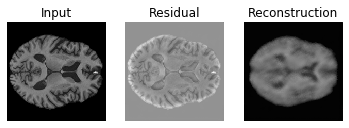

100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


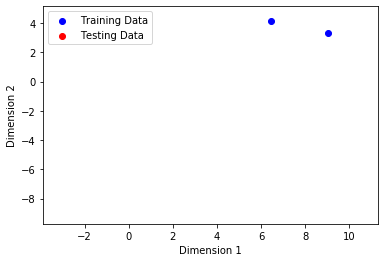

<Figure size 432x288 with 0 Axes>

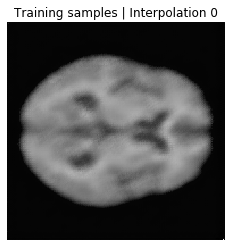

<Figure size 432x288 with 0 Axes>

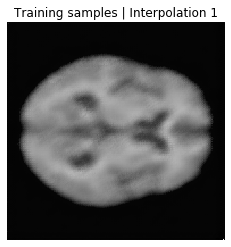

<Figure size 432x288 with 0 Axes>

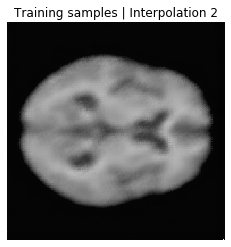

<Figure size 432x288 with 0 Axes>

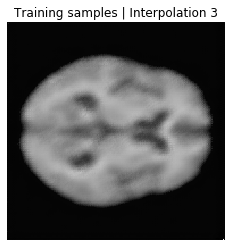

<Figure size 432x288 with 0 Axes>

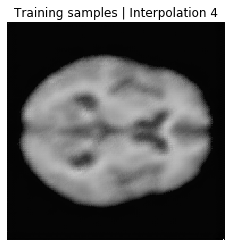

<Figure size 432x288 with 0 Axes>

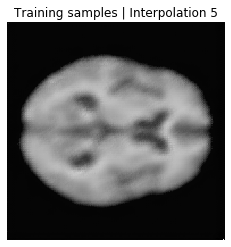

<Figure size 432x288 with 0 Axes>

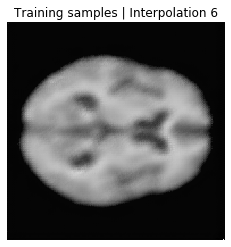

<Figure size 432x288 with 0 Axes>

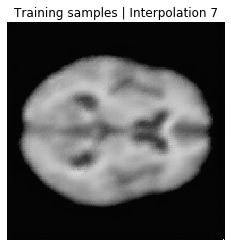

<Figure size 432x288 with 0 Axes>

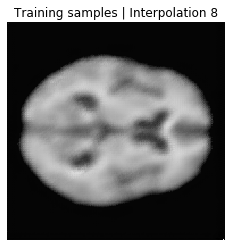

<Figure size 432x288 with 0 Axes>

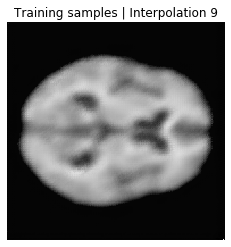

<Figure size 432x288 with 0 Axes>

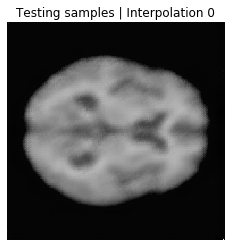

<Figure size 432x288 with 0 Axes>

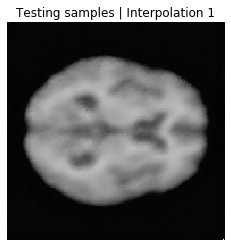

<Figure size 432x288 with 0 Axes>

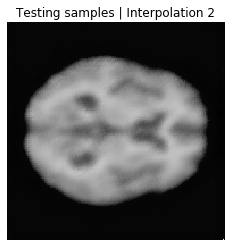

<Figure size 432x288 with 0 Axes>

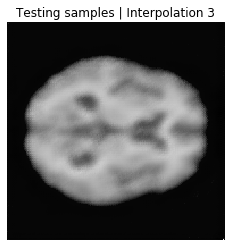

<Figure size 432x288 with 0 Axes>

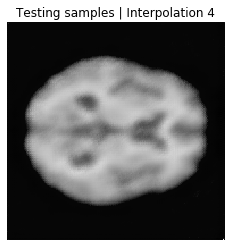

<Figure size 432x288 with 0 Axes>

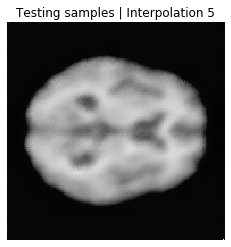

<Figure size 432x288 with 0 Axes>

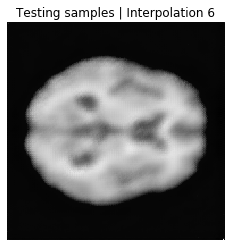

<Figure size 432x288 with 0 Axes>

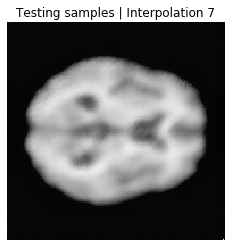

<Figure size 432x288 with 0 Axes>

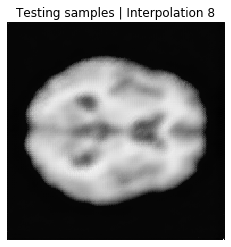

<Figure size 432x288 with 0 Axes>

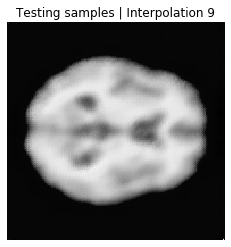

<Figure size 432x288 with 0 Axes>

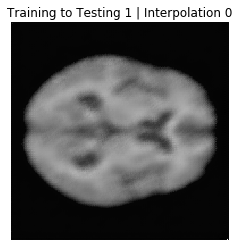

<Figure size 432x288 with 0 Axes>

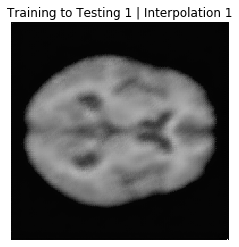

<Figure size 432x288 with 0 Axes>

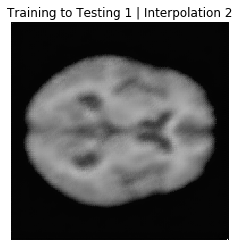

<Figure size 432x288 with 0 Axes>

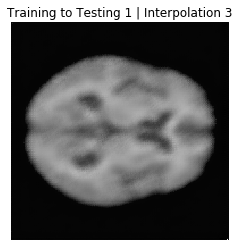

<Figure size 432x288 with 0 Axes>

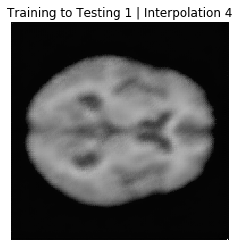

<Figure size 432x288 with 0 Axes>

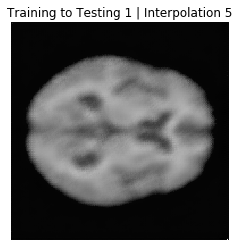

<Figure size 432x288 with 0 Axes>

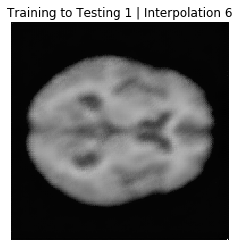

<Figure size 432x288 with 0 Axes>

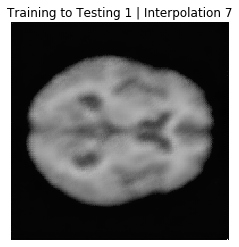

<Figure size 432x288 with 0 Axes>

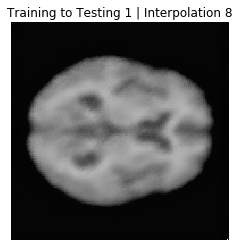

<Figure size 432x288 with 0 Axes>

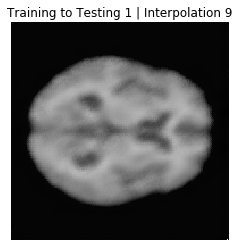

<Figure size 432x288 with 0 Axes>

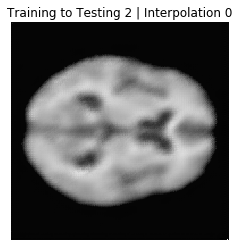

<Figure size 432x288 with 0 Axes>

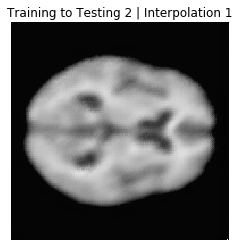

<Figure size 432x288 with 0 Axes>

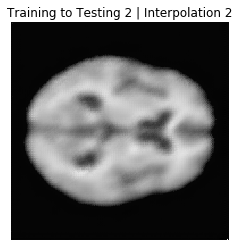

<Figure size 432x288 with 0 Axes>

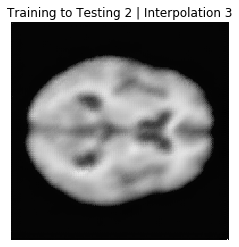

<Figure size 432x288 with 0 Axes>

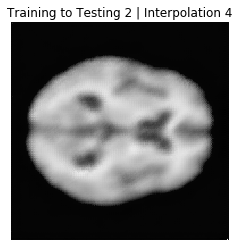

<Figure size 432x288 with 0 Axes>

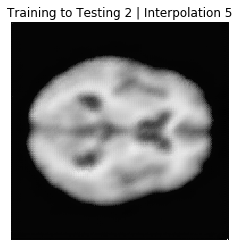

<Figure size 432x288 with 0 Axes>

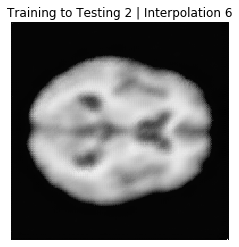

<Figure size 432x288 with 0 Axes>

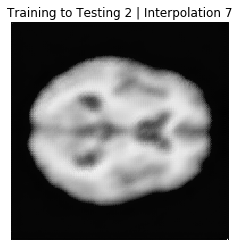

<Figure size 432x288 with 0 Axes>

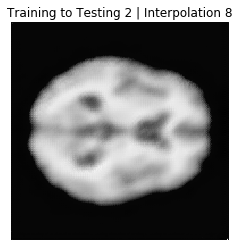

<Figure size 432x288 with 0 Axes>

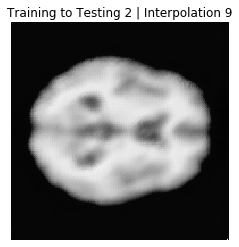

In [ ]:
experiment(
    code_processor_class=DenseAECodeProcessor, 
    code_processor_parameters={
      "feature_size":FEATURE_SIZE, 
      "depth":NETWORK_DEPTH, 
      "img_sizes":[96, 96], 
      "encoding_sizes":[1024,512,256],
      "decoding_sizes":[512,1024],
    }, 
    network_depth=NETWORK_DEPTH, 
    network_length=NETWORK_LENGTH, 
    feature_size=FEATURE_SIZE,
)

#Spatial AutoEncoder
For a *Spatial AutoEncoder* the *Code Processor* only passes the latent representation of the *Encoder* to the *Decoder*

----

To do:
*    Code the missing pices

----

Tips:
*    Do not overthink it



In [ ]:
class SpatialAECodeProcessor(nn.Module):
    def __init__(self):
      super(SpatialAECodeProcessor, self).__init__()

    def forward(self, x):
      #TODO:Code any tensor processing if needed
      return x

    def encode(self, x):
      #TODO:Code any tensor processing if needed
      return x

    def decode(self, x):
      #TODO:Code any tensor processing if needed
      return x

Now lets see what we get if we run it!

==== Epoch: 0 | L1 loss: 0.2318074 | L2 loss: 0.12420964 | Total Loss: 0.35601705 =====


<Figure size 432x288 with 0 Axes>

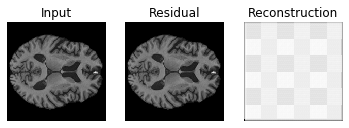

==== Epoch: 10 | L1 loss: 0.07550091 | L2 loss: 0.015973803 | Total Loss: 0.09147471 =====


<Figure size 432x288 with 0 Axes>

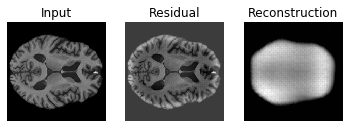

==== Epoch: 20 | L1 loss: 0.082442336 | L2 loss: 0.01948999 | Total Loss: 0.101932324 =====


<Figure size 432x288 with 0 Axes>

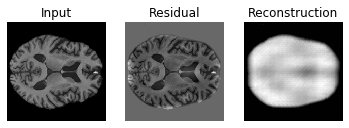

==== Epoch: 30 | L1 loss: 0.05152007 | L2 loss: 0.008138787 | Total Loss: 0.059658855 =====


<Figure size 432x288 with 0 Axes>

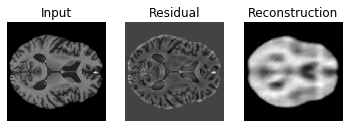

==== Epoch: 40 | L1 loss: 0.039778885 | L2 loss: 0.0053104744 | Total Loss: 0.04508936 =====


<Figure size 432x288 with 0 Axes>

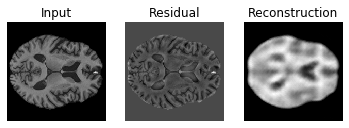

100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


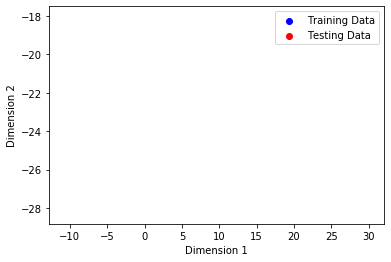

<Figure size 432x288 with 0 Axes>

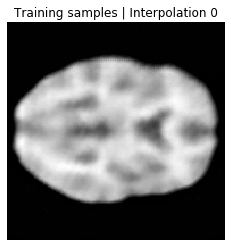

<Figure size 432x288 with 0 Axes>

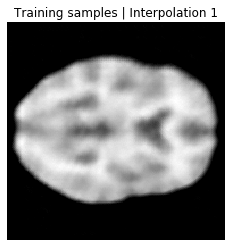

<Figure size 432x288 with 0 Axes>

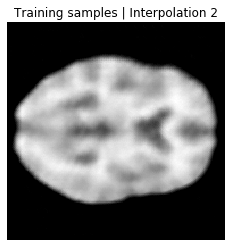

<Figure size 432x288 with 0 Axes>

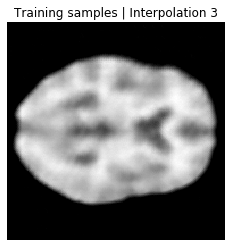

<Figure size 432x288 with 0 Axes>

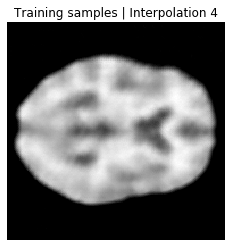

<Figure size 432x288 with 0 Axes>

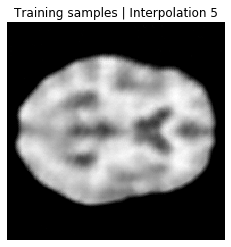

<Figure size 432x288 with 0 Axes>

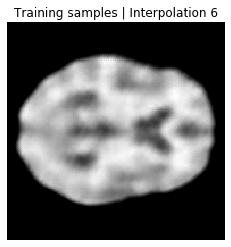

<Figure size 432x288 with 0 Axes>

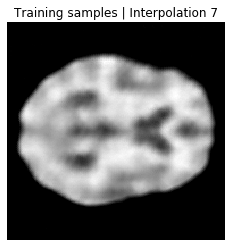

<Figure size 432x288 with 0 Axes>

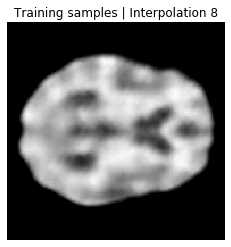

<Figure size 432x288 with 0 Axes>

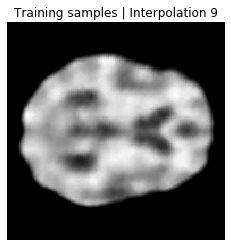

<Figure size 432x288 with 0 Axes>

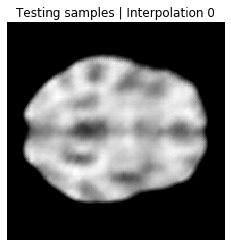

<Figure size 432x288 with 0 Axes>

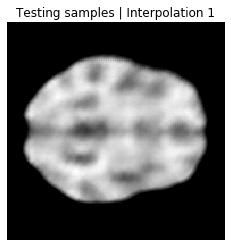

<Figure size 432x288 with 0 Axes>

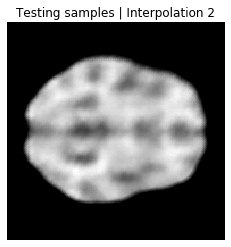

<Figure size 432x288 with 0 Axes>

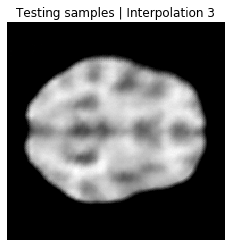

<Figure size 432x288 with 0 Axes>

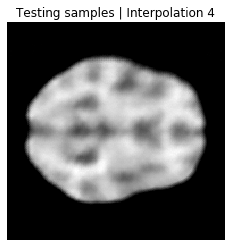

<Figure size 432x288 with 0 Axes>

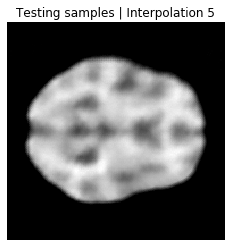

<Figure size 432x288 with 0 Axes>

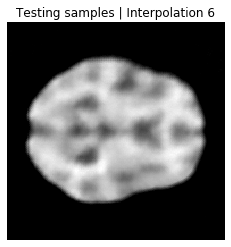

<Figure size 432x288 with 0 Axes>

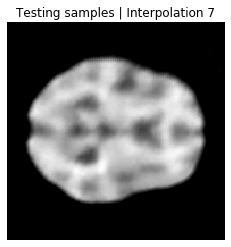

<Figure size 432x288 with 0 Axes>

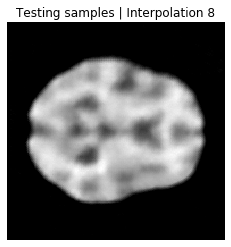

<Figure size 432x288 with 0 Axes>

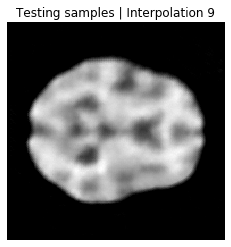

<Figure size 432x288 with 0 Axes>

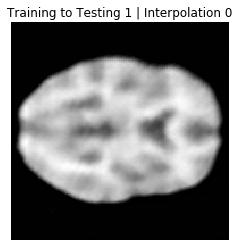

<Figure size 432x288 with 0 Axes>

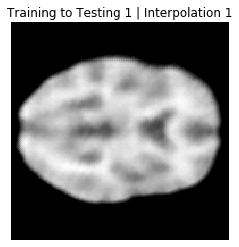

<Figure size 432x288 with 0 Axes>

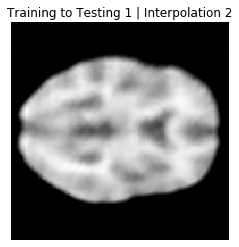

<Figure size 432x288 with 0 Axes>

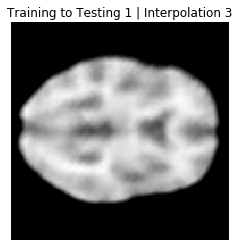

<Figure size 432x288 with 0 Axes>

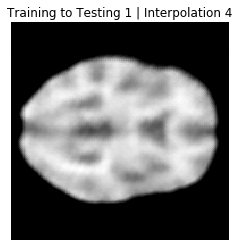

<Figure size 432x288 with 0 Axes>

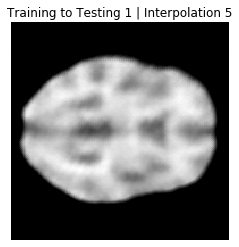

<Figure size 432x288 with 0 Axes>

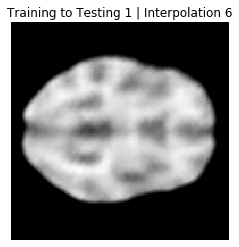

<Figure size 432x288 with 0 Axes>

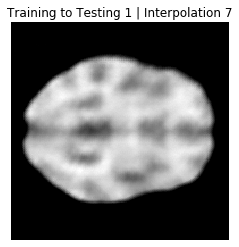

<Figure size 432x288 with 0 Axes>

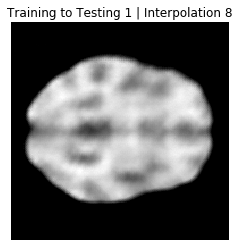

<Figure size 432x288 with 0 Axes>

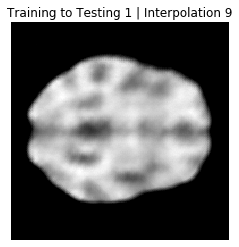

<Figure size 432x288 with 0 Axes>

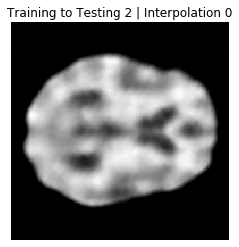

<Figure size 432x288 with 0 Axes>

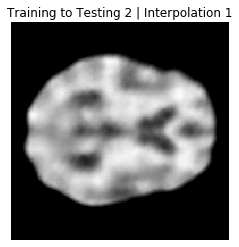

<Figure size 432x288 with 0 Axes>

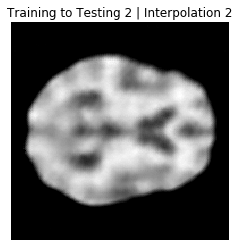

<Figure size 432x288 with 0 Axes>

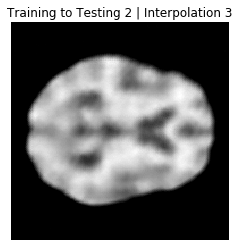

<Figure size 432x288 with 0 Axes>

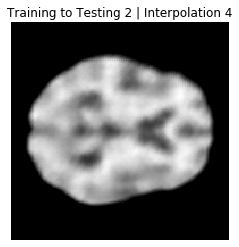

<Figure size 432x288 with 0 Axes>

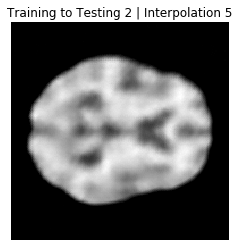

<Figure size 432x288 with 0 Axes>

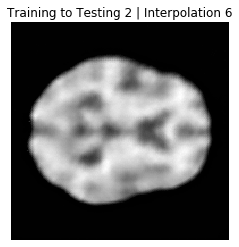

<Figure size 432x288 with 0 Axes>

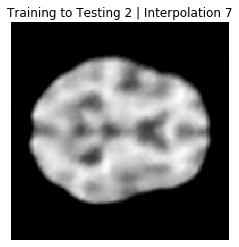

<Figure size 432x288 with 0 Axes>

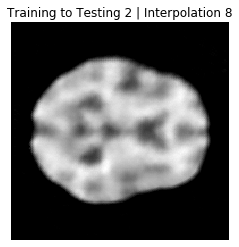

<Figure size 432x288 with 0 Axes>

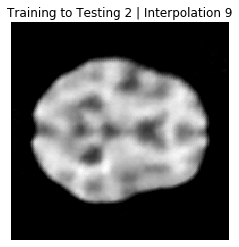

In [ ]:
experiment(
    code_processor_class=SpatialAECodeProcessor, 
    code_processor_parameters={}, 
    network_depth=NETWORK_DEPTH, 
    network_length=NETWORK_LENGTH, 
    feature_size=FEATURE_SIZE,
)

# Training Method (AE and VAE)
It is time to now modify most of the methods you wrote and enable them to **also** receive a **Variational AutoEncoder**.

The KL divergence is:

$D_{K L}[N(\mu(X), \Sigma(X)) \| N(0,1)]=\frac{1}{2} \sum_{k}\left(\exp (\Sigma(X))+\mu^{2}(X)-1-\Sigma(X)\right)$

----

To do:
*   Modify the signature of the method if needed
*   Modify the call to the forward pass 
*   Calculate the loss
*   Calculate the test loss
*   Change between training and testing modes

----

Tips:
*   Do not forget the method should be able to receive **either** a VAE or an AE
*   A **VAE** behaves **differently** in training and inference/testing/validation mode so you **can assume** that the VAEs will have a **.set_is_training()** method



In [ ]:
#TODO:Modify the signature if needed
def train_network(training_loader, testing_loader, network, is_vae):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  network.cuda(device)

  optimizer = optim.Adam(network.parameters(), lr=0.001)

  l1_loss = L1Loss()
  l2_loss = MSELoss()

  # Train the network
  for epoch in range(EPOCHS):
    for x in training_loader:
      # Move input to device
      x = x.to(device, dtype=torch.float)

      # Zero the parameter gradients
      optimizer.zero_grad()

      #TODO:Forward pass such that it can take either
      #     a VAE or an AE
      if is_vae:
        x_hat, code_mu, code_logvar = network(x)
      else:
        x_hat = network(x)

      #TODO:Calculate loss such that it can take either
      #     a VAE or an AE
      loss = l1_loss(x, x_hat) + l2_loss(x, x_hat)

      if is_vae:
        code_logvar = torch.flatten(code_logvar, start_dim=1)
        code_mu = torch.flatten(code_mu, start_dim=1)
        kl_divergence = (
          -0.5 * 
          torch.sum(
            1 + code_logvar - 
            code_mu.pow(2) - code_logvar.exp()
          )
        )
        kl_divergence = kl_divergence.mean()
        loss += kl_divergence


      # Back-propagation of gradients
      loss.backward()

      # Optimize
      optimizer.step()

    if epoch % 10 == 0:
      #TODO:Turn the network in testing mode
      network.set_is_training(is_training=False)

      #TODO:Initialize accumulators
      l1_test_loss = 0 
      l2_test_loss = 0 
      kl_test_loss = 0 
      for i, x in enumerate(testing_loader):
        x = x.to(device, dtype=torch.float)

        #TODO:Forward pass such that it can take either
        #     a VAE or an AE
        if is_vae:
          x_hat, code_mu, code_logvar = network(x)
        else:
          x_hat = network(x)

        #TODO:Calculate loss such that it can take either
        #     a VAE or an AE
        l1_test_loss = l1_loss(x, x_hat)
        l2_test_loss = l2_loss(x, x_hat)
        if is_vae:
          code_logvar = torch.flatten(code_logvar, start_dim=1)
          code_mu = torch.flatten(code_mu, start_dim=1)
          kl_divergence = (
            -0.5 * 
            torch.sum(
              1 + code_logvar - 
              code_mu.pow(2) - code_logvar.exp()
            )
          )
          kl_test_loss += kl_divergence.mean()

    
      print(
          "==== Epoch: " + str(epoch) + 
          " | L1 loss: " + str(numpy_from_tensor(l1_test_loss/i)) + 
          " | L2 loss: " + str(numpy_from_tensor(l2_test_loss/i)) +
          " | KL loss: " + str(numpy_from_tensor(kl_test_loss/i)) +
          " | Total Loss: " + str(numpy_from_tensor((l1_test_loss+l2_test_loss+kl_test_loss)/i))+ " =====")
      display_results(x, x_hat)
    #TODO:Turn the network back into training mode
    network.set_is_training(is_training=True)
  return network

# Unsupervised Network (AE and VAE)
You need to modify the class *UnsupervisedNetwork* such that is able to hold either a AE or a VAE.

----

To do:
*    Modify the signature of the *__init__* if needed
*    Modify the return elements of that the *code_processor()* returns since a VAE includes also a mean and a logvar besides the code
*    Same as above for the forward pass
*    Implement a class variable that tells us if the network is training or not

----

Tips:
*    Do not overthink it

In [ ]:
class UnsupervisedNetwork(nn.Module):
  #TODO:Modify the signature if needed
  def __init__(self, encoder, code_processor, decoder, is_vae):
    super(UnsupervisedNetwork, self).__init__()
    #TODO:Modify the class variables if needed
    self.is_vae = is_vae
    self.is_training=True
    self.encoder = encoder
    self.code_processor = code_processor
    self.decoder = decoder

  def forward(self, x):
    x = self.encoder(x)
    
    #TODO:Process encoder's latent representation
    #     to go through the code and get the desired
    #     input for the decoder
    if self.is_vae:
      x, mu, logvar = self.code_processor(x)
    else:
      x = self.code_processor(x)
    
    x = self.decoder(x)

    #TODO:change the output such that it matches
    #     either a VAE or an AE
    if self.is_vae:
      return x, mu, logvar
    else:
      return x

  def encode(self, x):
    x = self.encoder(x)
    x = self.code_processor.encode(x)

    return x

  def decode(self, x):
    x = self.code_processor.decode(x)
    x = self.decoder(x)
    return x
  
  #TODO:You might need a function to change
  #     if a network is training or not 
  def set_is_training(self, is_training):
    self.code_processor.set_is_training(is_training)

# Experiment design (AE and VAE)
You need to modify the method *experiment* such that it si able to take either a AE or a VAE.

----

To do:
*    Modify the signatures of the methods to adhere to all the modifications that you made

----

Tips:
*    Do not overthink it

In [ ]:
#TODO:Change the signature if needed and any other signature
def experiment(code_processor_class, code_processor_parameters, network_depth, network_length, feature_size, is_vae):
  network = UnsupervisedNetwork(
    encoder=Encoder(
      in_channels=1, 
      depth=network_depth, 
      length=network_length, 
      feature_size=feature_size
    ),
    decoder=Decoder(
      in_channels=np.power(feature_size,network_depth+1), 
      depth=network_depth, 
      length=network_length, 
      reconstruction_channels=1
    ),
    code_processor=code_processor_class(**code_processor_parameters),
    is_vae=is_vae
  )

  train_network(
      training_loader=training_loader,
      testing_loader=testing_loader,
      network=network,
      is_vae=is_vae
  )

  dimensionality_reduction_analysis(
      training_loader=training_loader,
      testing_loader=testing_loader,
      network=network
  )

  interpolation_analysis(
      training_loader=training_loader,
      testing_loader=testing_loader,
      network=network,
  )

# Dense Variational AutoEncoder
In a *Dense Variational AutoEncoder* the *Code Processor* receives the latent representation of the *Encoder* and then flattens it into a 1D array. Following that it is further compressed until the desired code dimension. Then a **mean** and **logvariance** are estimated and used in the **kernel trick**. The result of the kernel trick is  then decompresses while beeing keept a 1D array. Finally it reshapes it so it can be passed to the *Decoder*.

----

To do:
*   Complete the Dense autoencoder with **Linear** layers 
*   Implement the *kernel trick*
*   Code the functionality for forward pass, encoding and decoding

----

Tips:
*   Look at [flatten layer](https://pytorch.org/docs/stable/nn.html#torch.nn.Flatten) and pay attention to the **start_dim** parameter.
*   Look at the [view](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) method of tensors 
*   Be careful with the feature sizes, you might need to be able to calculate them
*   Might need to use [clamp](https://pytorch.org/docs/stable/torch.html#torch.clamp) on logvars

In [ ]:
class DenseVAECodeProcessor(nn.Module):
  #TODO:Change the signature if needed
  def __init__(self, feature_size, depth, img_sizes, encoding_sizes, decoding_sizes, is_training):
    super(DenseVAECodeProcessor, self).__init__()
    self.logvars_upper_bound = 50
    self.logvars_lower_bound = -self.logvars_upper_bound
    
    self.is_training = is_training
    feature_depth = feature_size * np.power(2, depth)
    img_sizes = [img_size/np.power(2,depth) for img_size in img_sizes]

    flatten_size = int(feature_depth * np.prod(img_sizes))

    ecoding_processor = OrderedDict()

    in_features = flatten_size

    #TODO:Given a list of Linear layers output sizes compress the
    #     feature to the desired code size
    for i in range(len(encoding_sizes)):
      ecoding_processor["ecoding_flatten_" + str(i)] = nn.Linear(
          in_features=in_features, 
          out_features=encoding_sizes[i],
      )
      in_features = encoding_sizes[i]

    self.ecoding_processor = nn.Sequential(ecoding_processor)

    #TODO:Create Linear layers for both logvariance and mean
    self.logvar = nn.Linear(
      in_features=in_features, 
      out_features=in_features,
    )

    self.mu = nn.Linear(
      in_features=in_features, 
      out_features=in_features,
    )

    decoding_processor = OrderedDict()

    #TODO:Given a list of Linear layers output sizes decompress the
    #     code to the needed size for the decoder
    for i in range(len(decoding_sizes)):
      decoding_processor["decoding_flatten_" + str(i)] = nn.Linear(
          in_features=in_features, 
          out_features=decoding_sizes[i],
      )
      in_features = decoding_sizes[i]
    
    decoding_processor["flatten_" + str(i+1)] = nn.Linear(
      in_features=in_features, 
      out_features=flatten_size,
    )

    self.decoding_processor = nn.Sequential(decoding_processor)

  def forward(self, x):
    self.spatial_shape = x.shape[1:]

    x = torch.flatten(x, start_dim=1)
    x = self.ecoding_processor(x)
    
    #TODO:Code the reparametrisation trick you will need to
    #     you need to take into account if the network
    #     is training or not
    logvar = torch.clamp(
        self.logvar(x),
        self.logvars_lower_bound,
        self.logvars_upper_bound
    )

    mu = self.mu(x)

    if self.is_training:
      std = logvar.mul(0.5).exp_()
      esp = torch.randn_like(mu)
      x = mu + std * esp
    else:
      x = mu

    x = self.decoding_processor(x)
    x = x.view((-1,) + self.spatial_shape)

    return x, mu, logvar

  def encode(self, x):
    #TODO:Code the necessary processing of the latent 
    #     representation
    x = torch.flatten(x, start_dim=1)
    x = self.ecoding_processor(x)
    x = self.mu(x)

    return x

  def decode(self, x):
    #TODO:Code the necessary processing of the latent 
    #     representation
    x = self.decoding_processor(x)
    x = x.view((-1,)+self.spatial_shape)

    return x
  
  #TODO:You might need a function to change
  #     if a network is training or not
  def set_is_training(self, is_training):
    self.is_training = is_training  

Now lets see what we get if we run it!

==== Epoch: 0 | L1 loss: 0.22902738 | L2 loss: 0.12289674 | KL loss: 0.7645643 | Total Loss: 1.1164885 =====


<Figure size 432x288 with 0 Axes>

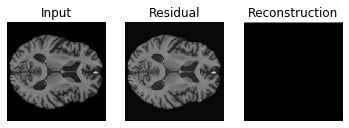

==== Epoch: 10 | L1 loss: 0.07484714 | L2 loss: 0.017470488 | KL loss: 3.9577484e-05 | Total Loss: 0.0923572 =====


<Figure size 432x288 with 0 Axes>

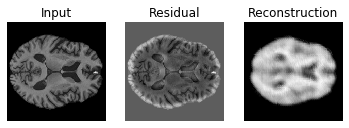

==== Epoch: 20 | L1 loss: 0.06881336 | L2 loss: 0.014792423 | KL loss: 3.874302e-05 | Total Loss: 0.083644524 =====


<Figure size 432x288 with 0 Axes>

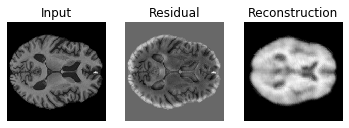

==== Epoch: 30 | L1 loss: 0.06691573 | L2 loss: 0.01360289 | KL loss: 2.8848648e-05 | Total Loss: 0.08054747 =====


<Figure size 432x288 with 0 Axes>

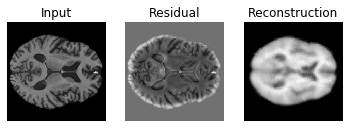

==== Epoch: 40 | L1 loss: 0.06680201 | L2 loss: 0.013819878 | KL loss: 3.3974648e-05 | Total Loss: 0.080655865 =====


<Figure size 432x288 with 0 Axes>

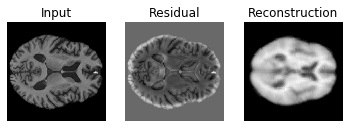

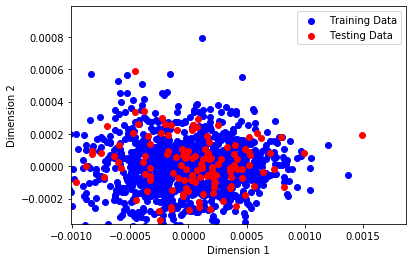

<Figure size 432x288 with 0 Axes>

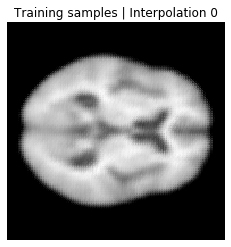

<Figure size 432x288 with 0 Axes>

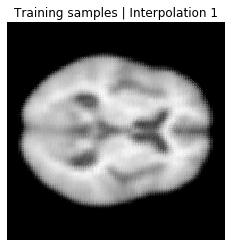

<Figure size 432x288 with 0 Axes>

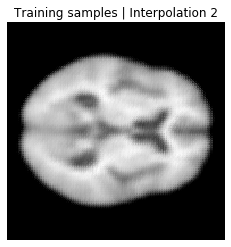

<Figure size 432x288 with 0 Axes>

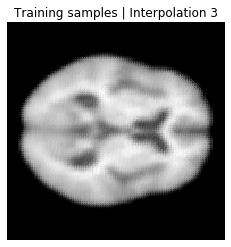

<Figure size 432x288 with 0 Axes>

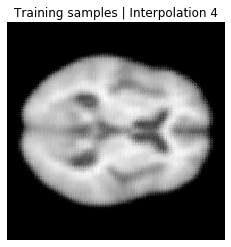

<Figure size 432x288 with 0 Axes>

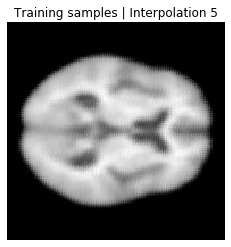

<Figure size 432x288 with 0 Axes>

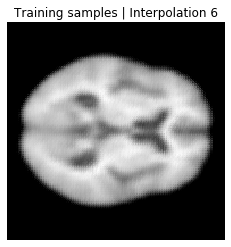

<Figure size 432x288 with 0 Axes>

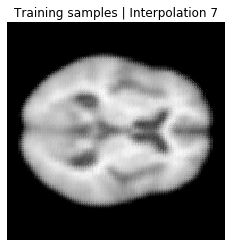

<Figure size 432x288 with 0 Axes>

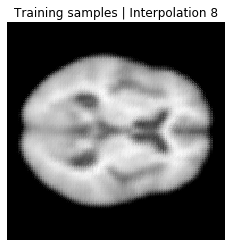

<Figure size 432x288 with 0 Axes>

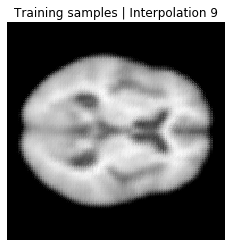

<Figure size 432x288 with 0 Axes>

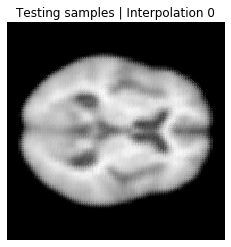

<Figure size 432x288 with 0 Axes>

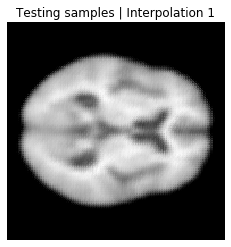

<Figure size 432x288 with 0 Axes>

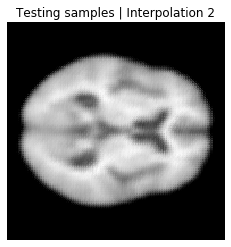

<Figure size 432x288 with 0 Axes>

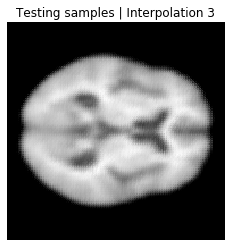

<Figure size 432x288 with 0 Axes>

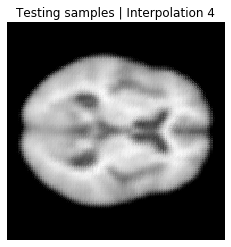

<Figure size 432x288 with 0 Axes>

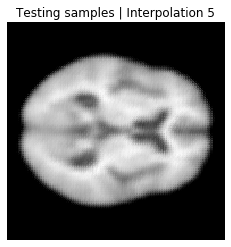

<Figure size 432x288 with 0 Axes>

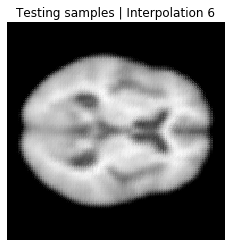

<Figure size 432x288 with 0 Axes>

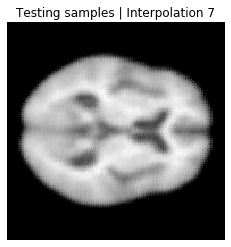

<Figure size 432x288 with 0 Axes>

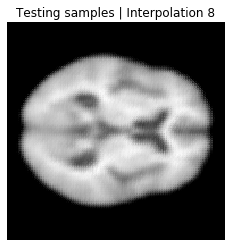

<Figure size 432x288 with 0 Axes>

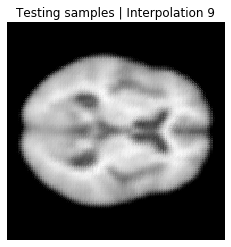

<Figure size 432x288 with 0 Axes>

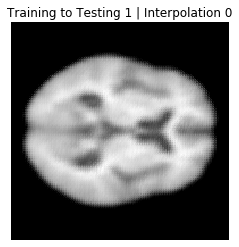

<Figure size 432x288 with 0 Axes>

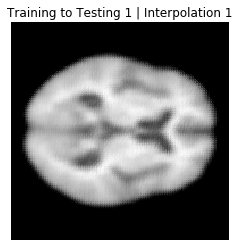

<Figure size 432x288 with 0 Axes>

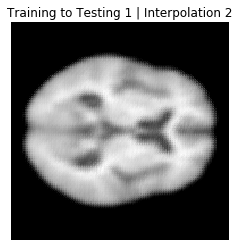

<Figure size 432x288 with 0 Axes>

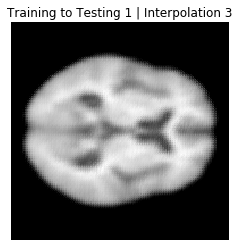

<Figure size 432x288 with 0 Axes>

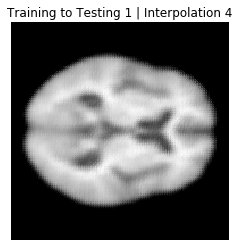

<Figure size 432x288 with 0 Axes>

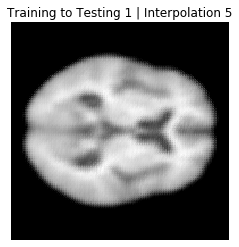

<Figure size 432x288 with 0 Axes>

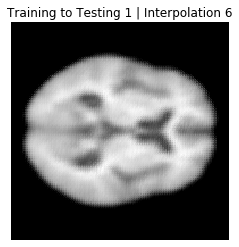

<Figure size 432x288 with 0 Axes>

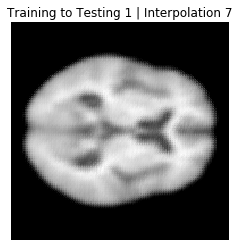

<Figure size 432x288 with 0 Axes>

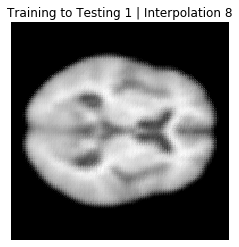

<Figure size 432x288 with 0 Axes>

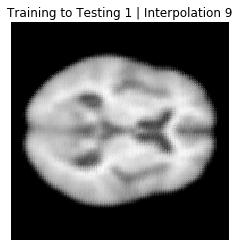

<Figure size 432x288 with 0 Axes>

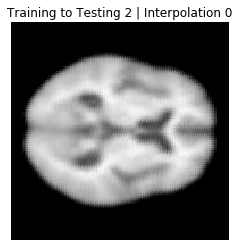

<Figure size 432x288 with 0 Axes>

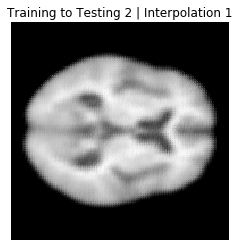

<Figure size 432x288 with 0 Axes>

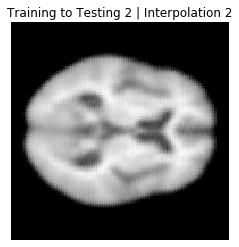

<Figure size 432x288 with 0 Axes>

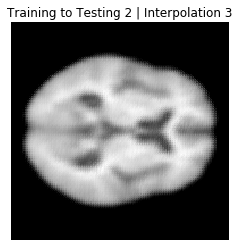

<Figure size 432x288 with 0 Axes>

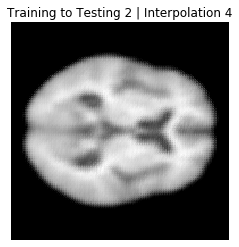

<Figure size 432x288 with 0 Axes>

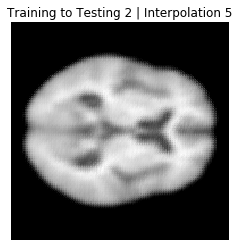

<Figure size 432x288 with 0 Axes>

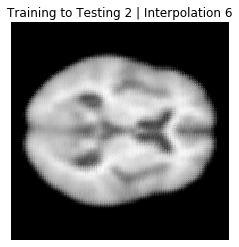

<Figure size 432x288 with 0 Axes>

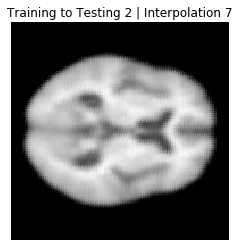

<Figure size 432x288 with 0 Axes>

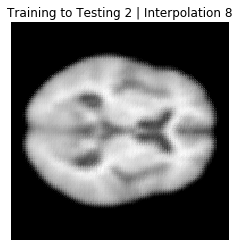

<Figure size 432x288 with 0 Axes>

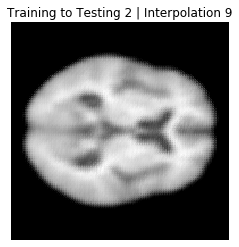

In [ ]:
#TODO:Make any signatures changes that you did in
#     the last cell that edited this method
experiment(
    code_processor_class=DenseVAECodeProcessor, 
    code_processor_parameters={
      "feature_size":FEATURE_SIZE, 
      "depth":NETWORK_DEPTH, 
      "img_sizes":[192,192], 
      "encoding_sizes":[1024,512,256],
      "decoding_sizes":[512,1024],
      "is_training":True,
    }, 
    network_depth=NETWORK_DEPTH, 
    network_length=NETWORK_LENGTH, 
    feature_size=FEATURE_SIZE,
    is_vae=True
)

# Spatial Variational AutoEncoder
In a *Spatial Variational AutoEncoder* the *Code Processor* receives the latent representation of the *Encoder* and then a **mean** and **logvariance** are estimated and used in the **kernel trick**. The result of the kernel trick is then passed to the *Decoder*.

----

To do:
*   Estimate the mean and variance
*   Implement the *kernel trick*
*   Code the functionality for forward pass, encoding and decoding

----

Tips:
*   Might need to use [clamp](https://pytorch.org/docs/stable/torch.html#torch.clamp) on logvars

In [ ]:
class SpatialVAECodeProcessor(nn.Module):
    def __init__(self, feature_size, depth, is_training):
      super(SpatialVAECodeProcessor, self).__init__()
      self.logvars_upper_bound = 50
      self.logvars_lower_bound = -self.logvars_upper_bound
      self.is_training = is_training
      
      feature_depth = feature_size * np.power(2, depth)
      
      #TODO:Create 2D Convolutional layers for the logvar
      #     and mean
      self.logvar = nn.Conv2d(
        in_channels=feature_depth, 
        out_channels=feature_depth, 
        kernel_size=3, 
        stride=1,
        padding=1, 
      )

      self.mu = nn.Conv2d(
        in_channels=feature_depth, 
        out_channels=feature_depth, 
        kernel_size=3, 
        stride=1,
        padding=1, 
      )

    def forward(self, x):
      #TODO:Code the reparametrisation trick you will need to
      #     you need to take into account if the network
      #     is training or not
      logvar = torch.clamp(
          self.logvar(x),
          self.logvars_lower_bound,
          self.logvars_upper_bound
      )

      mu = self.mu(x)

      if self.is_training:
        std = logvar.mul(0.5).exp_()
        esp = torch.randn_like(mu)
        x = mu + std * esp
      else:
        x = mu

      return x, mu, logvar
    
    def encode(self, x):
      #TODO:Code the necessary processing of the latent
      #     representation
      x = self.mu(x)
      return x

    def decode(self, x):
      return x

    def set_is_training(self, is_training):
      self.is_training = is_training   

Now lets see what we get if we run it!

==== Epoch: 0 | L1 loss: 0.23336087 | L2 loss: 0.075713985 | KL loss: 3.975457 | Total Loss: 4.2845316 =====


<Figure size 432x288 with 0 Axes>

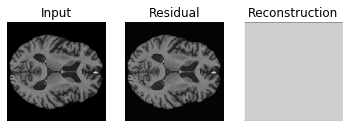

==== Epoch: 10 | L1 loss: 0.23348409 | L2 loss: 0.124199785 | KL loss: 0.04492131 | Total Loss: 0.40260518 =====


<Figure size 432x288 with 0 Axes>

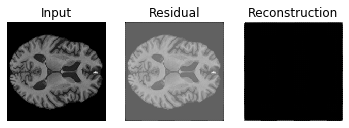

==== Epoch: 20 | L1 loss: 0.23245865 | L2 loss: 0.12377039 | KL loss: 0.010676235 | Total Loss: 0.36690527 =====


<Figure size 432x288 with 0 Axes>

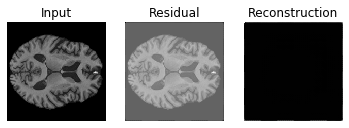

==== Epoch: 30 | L1 loss: 0.23066123 | L2 loss: 0.12197431 | KL loss: 0.006375611 | Total Loss: 0.35901114 =====


<Figure size 432x288 with 0 Axes>

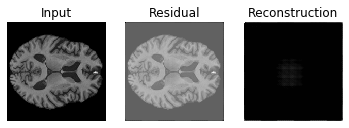

==== Epoch: 40 | L1 loss: 0.20193264 | L2 loss: 0.100233175 | KL loss: 0.0022631586 | Total Loss: 0.30442896 =====


<Figure size 432x288 with 0 Axes>

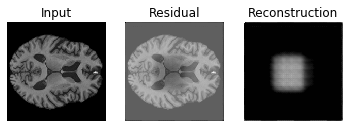

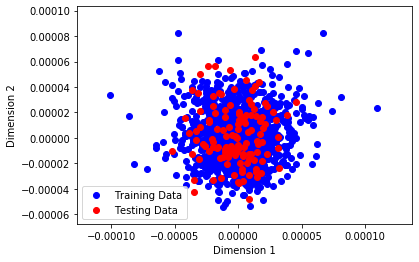

<Figure size 432x288 with 0 Axes>

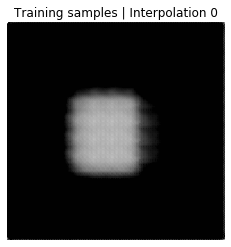

<Figure size 432x288 with 0 Axes>

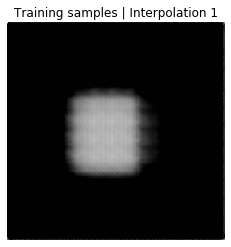

<Figure size 432x288 with 0 Axes>

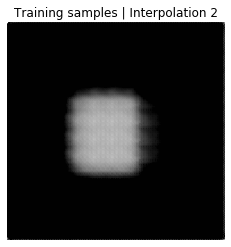

<Figure size 432x288 with 0 Axes>

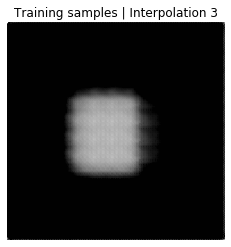

<Figure size 432x288 with 0 Axes>

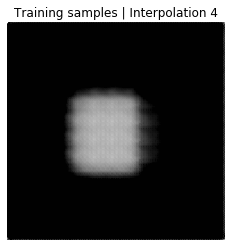

<Figure size 432x288 with 0 Axes>

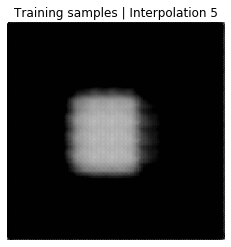

<Figure size 432x288 with 0 Axes>

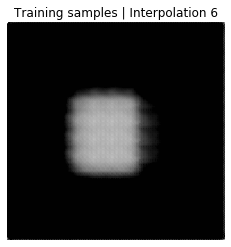

<Figure size 432x288 with 0 Axes>

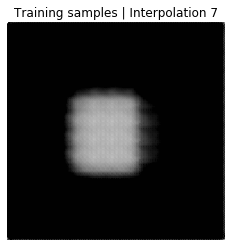

<Figure size 432x288 with 0 Axes>

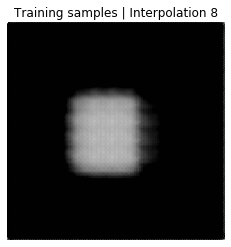

<Figure size 432x288 with 0 Axes>

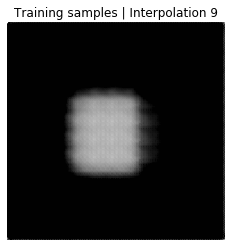

<Figure size 432x288 with 0 Axes>

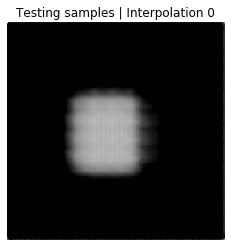

<Figure size 432x288 with 0 Axes>

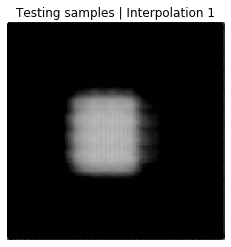

<Figure size 432x288 with 0 Axes>

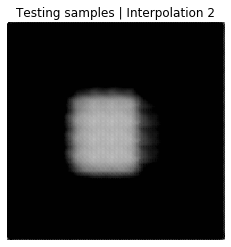

<Figure size 432x288 with 0 Axes>

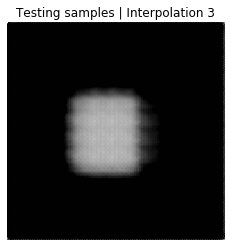

<Figure size 432x288 with 0 Axes>

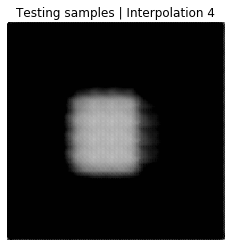

<Figure size 432x288 with 0 Axes>

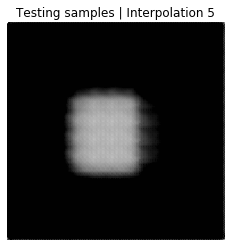

<Figure size 432x288 with 0 Axes>

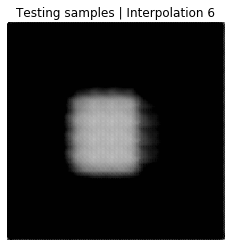

<Figure size 432x288 with 0 Axes>

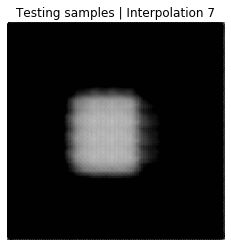

<Figure size 432x288 with 0 Axes>

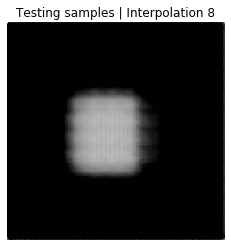

<Figure size 432x288 with 0 Axes>

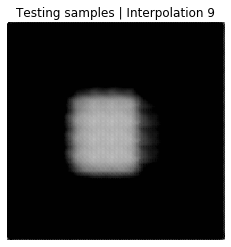

<Figure size 432x288 with 0 Axes>

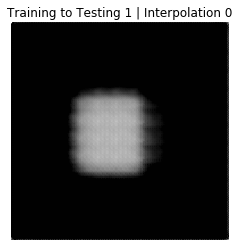

<Figure size 432x288 with 0 Axes>

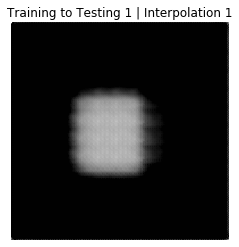

<Figure size 432x288 with 0 Axes>

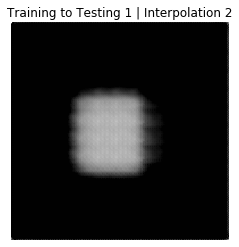

<Figure size 432x288 with 0 Axes>

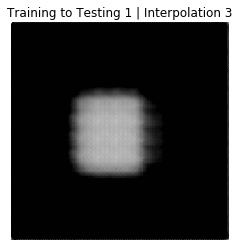

<Figure size 432x288 with 0 Axes>

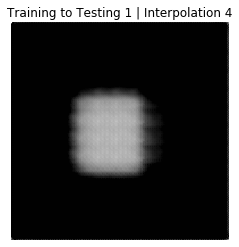

<Figure size 432x288 with 0 Axes>

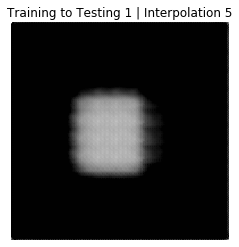

<Figure size 432x288 with 0 Axes>

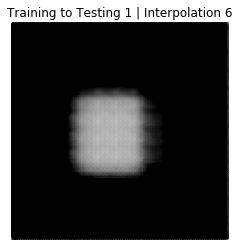

<Figure size 432x288 with 0 Axes>

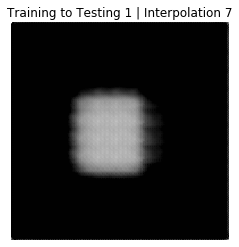

<Figure size 432x288 with 0 Axes>

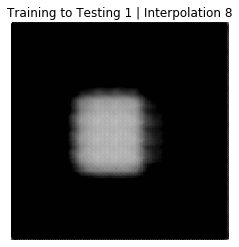

<Figure size 432x288 with 0 Axes>

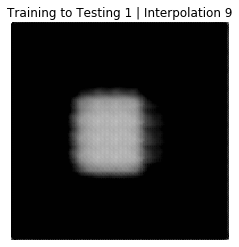

<Figure size 432x288 with 0 Axes>

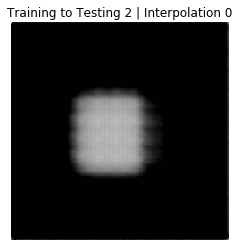

<Figure size 432x288 with 0 Axes>

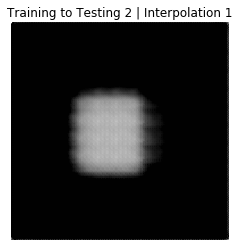

<Figure size 432x288 with 0 Axes>

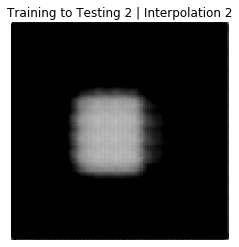

<Figure size 432x288 with 0 Axes>

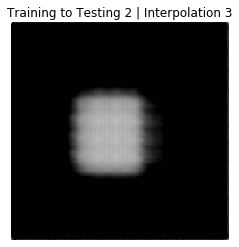

<Figure size 432x288 with 0 Axes>

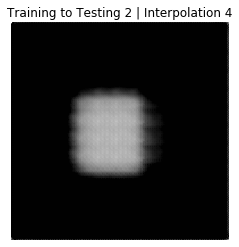

<Figure size 432x288 with 0 Axes>

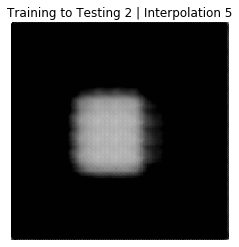

<Figure size 432x288 with 0 Axes>

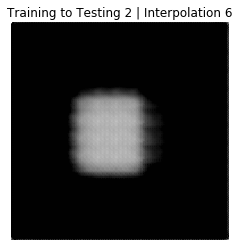

<Figure size 432x288 with 0 Axes>

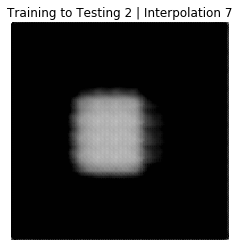

<Figure size 432x288 with 0 Axes>

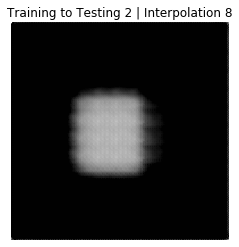

<Figure size 432x288 with 0 Axes>

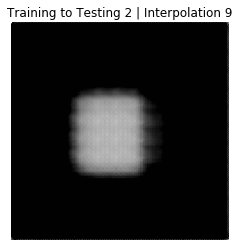

In [ ]:
#TODO:Make any signatures changes that you did in
#     the last cell that edited this method
experiment(
    code_processor_class=SpatialVAECodeProcessor, 
    code_processor_parameters={
      "feature_size":FEATURE_SIZE, 
      "depth":NETWORK_DEPTH+1, 
      "is_training":True,
    }, 
    network_depth=NETWORK_DEPTH+1, 
    network_length=NETWORK_LENGTH, 
    feature_size=FEATURE_SIZE,
    is_vae=True
)